# Imports

In [11]:
import pandas as pd
from datetime import datetime
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
import sklearn as sk
import sklearn.neural_network as sknn


# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* 

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [12]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])
# full_table = full_table.sort_values(['Date','Country/Region'],ascending=[True, False])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
31611,Sichuan,China,30.6171,102.7103,2020-05-20,561,3,558,0
31331,Hong Kong,China,22.3000,114.2000,2020-05-19,1055,4,1025,26
26302,Jilin,China,43.6661,126.1923,2020-04-30,111,1,101,9
16922,,Venezuela,6.4238,-66.5897,2020-03-25,91,0,15,76
9712,,Niger,17.6078,8.0817,2020-02-27,0,0,0,0
11869,,Thailand,15.0000,101.0000,2020-03-06,48,1,31,16


## Population Dataset


In [13]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [14]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [15]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
30247,Grand Princess,Canada,37.6489,-122.6655,2020-05-15,13,0,0,13
14031,,MS Zaandam,0.0000,0.0000,2020-03-14,0,0,0,0
6927,Grand Princess,Canada,37.6489,-122.6655,2020-02-17,0,0,0,0
5531,Diamond Princess,Canada,0.0000,0.0000,2020-02-11,0,0,0,0
15071,Diamond Princess,Canada,0.0000,0.0000,2020-03-18,0,0,0,0
14541,Diamond Princess,Canada,0.0000,0.0000,2020-03-16,0,0,0,0


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [16]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [17]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [18]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

In [19]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()


### Adding population
In this section, we merge both datasets by Country/Region.

In [20]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])


In [21]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30976 entries, 0 to 30975
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              30976 non-null  object        
 1   Lat                         30976 non-null  float64       
 2   Long                        30976 non-null  float64       
 3   Date                        30976 non-null  datetime64[ns]
 4   Confirmed                   30976 non-null  int64         
 5   Deaths                      30976 non-null  int64         
 6   Recovered                   30976 non-null  int64         
 7   Active                      30976 non-null  int64         
 8   Population                  30976 non-null  int64         
 9   Population Density (P/Km²)  30976 non-null  int64         
 10  Urban Population %          30976 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)


array([], dtype=object)

### Calculating Cases per Million of People




In [22]:
# full_grouped.isna().sum()

Country/Region                0
Lat                           0
Long                          0
Date                          0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

,Date,Country/Region,Province/State,C/D/R,Cases
0,2020-01-22,Portugal,,Confirmed,0
1,2020-01-22,Spain,,Confirmed,0
2,2020-01-23,Portugal,,Confirmed,0
3,2020-01-23,Spain,,Confirmed,0
4,2020-01-24,Portugal,,Confirmed,0
...,...,...,...,...,...
721,2020-05-19,Spain,,Recovered,150376
722,2020-05-20,Portugal,,Recovered,6452
723,2020-05-20,Spain,,Recovered,150376
724,2020-05-21,Portugal,,Recovered,6452


,count,mean,std,min,25%,50%,75%,max
Lat,242.0,39.699950,0.300672,39.3999,39.3999,39.69995,40.00,40.0
Long,242.0,-6.112250,2.116628,-8.2245,-8.2245,-6.11225,-4.00,-4.0
Confirmed,242.0,49057.822314,79008.843934,0.0000,2.0000,6399.50000,29849.00,233037.0
Deaths,242.0,4978.880165,9076.110264,0.0000,0.0000,150.00000,1672.75,27940.0
Recovered,242.0,21103.297521,42947.789842,0.0000,0.0000,68.00000,6164.25,150376.0
Active,242.0,22975.644628,31153.122758,0.0000,1.0000,6012.50000,24332.00,101617.0


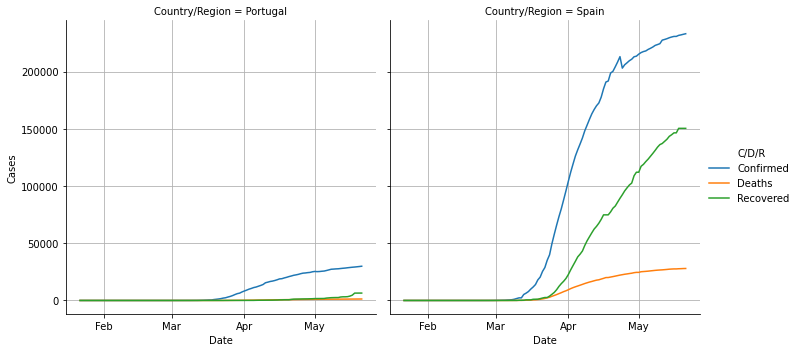

In [25]:

portugal_data = full_table.loc[(full_table['Country/Region'] == 'Portugal') | (full_table['Country/Region'] == 'Spain')]
things = ['Confirmed','Deaths','Recovered']
dd = portugal_data.melt(['Date','Country/Region','Province/State'],var_name='C/D/R', value_name='Cases',value_vars=things)


chart = sb.relplot(x='Date',y='Cases',hue='C/D/R',col='Country/Region',data=dd,kind='line')

axs = chart.axes

days = mdates.MonthLocator(interval=1)
months = mdates.MonthLocator()  # every month
days_fmt = mdates.DateFormatter('%b')

for ax in axs[0]:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(days_fmt)
    ax.xaxis.set_minor_locator(days)

    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)


include = ['datetime64', 'float', 'int'] 
dd.describe(include = include).transpose()


display(dd)
portugal_data.describe().transpose()



In [132]:
def parseForNN(df):
    return df[['Lat','Long','Date']], df[['Confirmed','Deaths','Recovered']]

def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,1).toordinal()

X,Y = parseForNN(portugal_data)
X['Date'] = X['Date'].map(daysSinceJan)
X = X.values
Y = Y.values

nn = sknn.MLPRegressor(
    hidden_layer_sizes=(10,20,1000,20,10),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    max_iter=1000,
    verbose=True
    )

nn.fit(X,Y)



523715272.19902194
Iteration 450, loss = 522951930.80055815
Iteration 451, loss = 522181426.13341099
Iteration 452, loss = 519008536.03827077
Iteration 453, loss = 517905567.55195034
Iteration 454, loss = 514225161.30049938
Iteration 455, loss = 518001982.26936591
Iteration 456, loss = 515555970.83965880
Iteration 457, loss = 512324220.52978122
Iteration 458, loss = 508466389.45176625
Iteration 459, loss = 507195753.87985498
Iteration 460, loss = 505503464.04257983
Iteration 461, loss = 504859811.11768448
Iteration 462, loss = 502545752.59836215
Iteration 463, loss = 499657757.00543094
Iteration 464, loss = 499173024.60557181
Iteration 465, loss = 505667004.25232273
Iteration 466, loss = 501643565.95205396
Iteration 467, loss = 496692040.03097034
Iteration 468, loss = 493998012.20413512
Iteration 469, loss = 492489148.05125135
Iteration 470, loss = 489575675.04893881
Iteration 471, loss = 489670866.61361015
Iteration 472, loss = 489816914.03266609
Iteration 473, loss = 487140136.971496

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 20, 1000, 20, 10),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=1000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
             verbose=True, warm_start=False)

In [133]:
display(covid_data.loc[(covid_data['Country/Region'] == 'Portugal') & (covid_data['Date'] == datetime(2020,4,2))])

NameError: name 'covid_data' is not defined

In [134]:
nn.predict([[39.3999,-8.2245,daysSinceJan(datetime(2020,5,8)) ]])

array([[29396.65707172,   277.11543779, -2302.88473788]])